# Data preparation

In [5]:
import regex as re

from PyPDF2 import PdfReader
import pandas as pd
import numpy as np


## Felci NZ
### Extract PDF

In [214]:
from tqdm.auto import tqdm

fern_species = pd.read_excel("Species list.xlsx")

conditional_newline = lambda sp: '\s*\n?'.join(sp.split(' ')).replace('.', '\.').replace('(', '\(').replace(')', '\)').replace('[', '\[').replace(']', '\]')
sp_descriptions = pd.DataFrame()
for fam in tqdm(fern_species.Family.unique()):
    text = ""
    with open(f"descriptions/{fam}.pdf", "rb") as pdf_file:
        read_pdf = PdfReader(pdf_file)
        for i, page in enumerate(read_pdf.pages):
            if i < 5:
                continue
            tx = page.extract_text()
            if tx.split("\n")[0].startswith('References'):
                # print(f"Breaking at page {i}")
                break
            text += page.extract_text()
    text = re.sub(r'[^\S\r\n]+', ' ', text)

    fam_species = fern_species[fern_species.Family.eq(fam)].Species.unique()
    sp_dict = {}
    for i, species in enumerate(fam_species):
        species = species
        if (cnt := len(re.findall(conditional_newline(species), text))) == 0:
            print(f"{fam} | {species} wrongly appearing (count: {cnt})")
            raise ValueError
        # start = text.find(species)
        # start is the first character of the species name assuming to find it in the text
        # with potentially some '\n' characters in between
        start = re.search(conditional_newline(species), text).start()
        end = [re.search(conditional_newline(sp), text).start() for sp in fam_species]
        end = min([e for e in end if e and e > start] + [len(text)])
        name_sp = species.split(')')[0] + ')'
        if name_sp not in sp_dict.keys():
            sp_dict[name_sp] = text[start:end]
        else:
            sp_dict[name_sp] += '\n' + text[start:end]

    sp_descriptions = pd.concat([sp_descriptions, pd.DataFrame(sp_dict.items(), columns=['Species', 'Description']).assign(Family=fam)], ignore_index=True)


def desc_to_sections(desc):
    """
    Split the description into sections:
    "Etymology", "Vernacular name", "Distribution", "Altitudinal range", "Biostatus", "Habitat", "First record ", "Recognition ", "Cytology", "Hybridisation", "Notes "
    not all the sections will be present in all descriptions, if present, they start with the section name followed by a colon, up to the next named section or the end of the description
    """
    sections = ["Etymology", "Vernacular name", "Distribution", "Altitudinal range", "Biostatus", "Habitat", "First record", "Recognition", "Cytology", "Hybridisation", "Notes"]
    section_dict = {}
    for i, section in enumerate(sections):
        if i == len(sections) - 1:
            section_dict[section] = desc
        else:
            start = re.search(fr"{section}s?:", desc)
            start = start.end() if start else -1
            if start == -1:
                continue
            end = re.search(fr"{sections[i+1]}s?:", desc)
            end = end.start() if end else -1

            this_desc = desc[start:end].strip()

            section_dict[section] = re.sub(r'\n+', ' ', this_desc.strip())
    return pd.Series(section_dict)

extra = sp_descriptions.Description.apply(desc_to_sections)  
sp_descriptions = pd.concat([sp_descriptions, extra], axis=1).drop(columns='Description')

NameError: name 'fern_species' is not defined

In [50]:
sp_descriptions.to_excel("fern_descriptions.xlsx", index=False)

### Extract features

In [215]:
sp_descriptions = pd.read_excel("fern_descriptions.xlsx").set_index('Species')

In [216]:
extra_features_df = pd.read_excel("../Words before and after traits_v2.xlsx", sheet_name="FernPrecedingWords")
extra_features_df = extra_features_df.drop(columns=[c for c in extra_features_df.columns if 'Unnamed' in c])
extra_features_df = extra_features_df[
    :extra_features_df[extra_features_df.Rhizome.str.startswith('Sentences that talk a', na=False)].index[0]
    ].map(lambda s:s.lower().strip() if type(s) == str else s)

extra_features = extra_features_df.to_dict('list')
extra_features = {k.title().replace(' ', ''): [x for x in v if str(x) != 'nan'] for k, v in extra_features.items()}

In [137]:
extra_features

{'Rhizome': ['Rhizome', 'Rhizomes', 'Stem', 'Stems'],
 'Frond': ['Fronds', 'Frond', 'Leaf', 'Leaves'],
 'FertileFronds': ['Fertile'],
 'SterileFronds': ['Sterile'],
 'Stipe': ['Stipe', 'Stipes'],
 'Rachis': ['Rachis', 'Rachises'],
 'Laminae': ['Laminae', 'Lamina'],
 'Sori': ['Sori', 'Sorus'],
 'Spores': ['Spores', 'Spore'],
 'Sporangia': ['Sporangia', 'Sporangium', 'Synangia', 'Synangium'],
 'Habitat': ['Aquatic',
  'Epiphytic',
  'Creeping',
  'Climbing',
  'Climber',
  'Climbers',
  'Creeper',
  'Creepers',
  'Terrestrial',
  'Lithophytic'],
 'Indusia': ['Indusia', 'Indusium'],
 'Habit': ['Creeping, Terrestrial, Both'],
 'Biostatus': ['Indigenous',
  'Native',
  'Exotic',
  'Endemic',
  'Non-Endemic',
  'Casual',
  'Fully Naturalized']}

In [5]:
unit = '[m|c|d|μ]?m'
number = r"(\d+\.?\d*)"
full_regex = rf"(({number}\s?-\s?)?{number})?({number}\s?-\s?)?{number}\s*{unit}(-wide)?(-long)?"

In [234]:
feat = 'Rhizomes short-to long-creeping, up to 100mm-long (in herbarium specimens), 0.8-1.7mm in diameter, with stipes arising 1-9mm apart; bearing scales'
candidate_feat = {}
for key, values in extra_features.items():
    if key in ('Habit', 'Venation', 'Biostatus', 'Habitat'):
        continue
    matched_word = list(re.finditer( r'\b('+ '|'.join([w for w in set(values)]) + r')\b', feat.lower()))
    if any(matched_word):
        candidate_feat[key] = matched_word[0]
if any(candidate_feat):
# feat is the first appearing candidate_feat
    key = sorted(candidate_feat, key=lambda x: candidate_feat[x].start())[0]
    matched_word = candidate_feat[key]
key, matched_word

('Rhizome', <re.Match object; span=(0, 8), match='rhizomes'>)

In [327]:
tmp = []
anomalies = set() # species with anomalies

def extract_features(i, feats:list):
	features = {}
	for feat in feats:
		if len(feat) < 1:
			continue
		feat = feat.replace(',', ' ')
		feat = feat[:-1] if feat[-1] in ['.', ';'] else feat # remove any of .; at the end of the sentence

		candidate_feat = {}
		for key, values in extra_features.items():
			if key in ('Habit', 'Venation', 'Biostatus', 'Habitat'):
				continue
			matched_word = list(re.finditer( r'\b('+ '|'.join([w for w in set(values)]) + r')\b', feat.lower()))
			if any(matched_word):
				candidate_feat[key] = matched_word[0]
		if not any(candidate_feat):
			continue
		key = sorted(candidate_feat, key=lambda x: candidate_feat[x].start())[0]
		matched_word = candidate_feat[key]

		if key == 'Rhizome':
			features['Habit'] = list(set(features.get('Habit', []) + [x for x in extra_features['Habit'] if x in feat.lower()]))
		
		measures = re.finditer(full_regex, feat)
		for measure in measures:
			if key == 'Laminae' and 'primary' in feat.lower() and len(features.get('Laminae', [])) >= 2:
				continue
			if key == 'PrimaryPinnae' and 'secondary' in feat.lower() and len(features.get('PrimaryPinnae', [])) >= 2:
				continue
			
			if key in ['Stipe', 'Laminae', 'Rhizome'] and len(features.get(key, [])) > 1: # TODO: da verificare per caso speciale
				hair_or_scale_position = list(re.finditer(r'(hair|scale)', feat.lower()))
				# C1: Se nella frase dello stipe trovi le keyword "hair", "hairs", "scale", "scales", i valori dopo queste keyword vanno ignorati.
				if any(hair_or_scale_position) and hair_or_scale_position[0].start() < measure.start():
					continue

			features[key] = features.get(key, []) + [measure.group()]
	return pd.Series(features)


In [328]:
def string_preprocessing(s):
	s = s.replace('\xa0', ' ').replace('×', 'x').replace('–', '-').replace('·', '.') # remove non-breaking space and replace multiplication sign with x
	s = re.sub(r'(?<=xcluding)\s+[\w-]+', ' ', s) # remove each word following "excluding" (Mericarps (excluding style) 2.5-3.0 mm should point to "Mericarps")
	s = re.sub(fr'-?\(-?{number}-?\)-?', '', s) # remove all parentesis surrounding a number and the number inside (e.g. (-1.5) --> **)
	s = re.sub(rf'(?<=\d)\s+(?={unit})', '', s) # remove all spaces before measures (mm, cm, dm, m, these strings only if padded by a space)
	s = re.sub('m long;?', 'm-long', s) # remove space between measure and "long" (e.g. 2 mm long --> 2 mm-long)
	s = re.sub('m wide;?', 'm-wide', s) # remove space between measure and "wide" (e.g. 2 mm wide --> 2 mm-wide)
	s = re.sub(r'\s*-\s*', '-', s) # remove spaces around hyphens
	s = re.sub(r'(?<=\d)\s*\.(?=\d)', '.', s) # remove spaces before dot if followed and preceded by a number
	s = re.sub(r'(?<=\s)\.(?=\d)', '0.', s) # add a 0 before a dot if it is preceded by a space and a "not number" and followed by a number (e.g. foo .5 --> foo 0.5)
	# s = re.sub(r'(?<=[\dm])\s*x\s*(?=\d+)', 'x', s) # remove spaces around x in formulas
	s = re.sub(rf'(;\s*)({full_regex})', r' \2', s) # point to any ';' preceding a measure (full_regex) and remove it, without removing the measure
	return s

In [329]:
features = sp_descriptions.Etymology.fillna('') + ' ' + sp_descriptions['Vernacular name'].fillna('')
# delimiter any of '. ', '.\n' and similar (all the dots not followed by numbers and not preceded by ' c', enforced with a negative lookbehind)
delimiter = r'(?<! c)\.(?!\d)|(; (?=sterile)|(; (?=fertile)))'
delimiter += '|' + '|'.join([f"(; (?={x.lower()}))" for x in extra_features.keys() if x not in ('Habit', 'Venation', 'Biostatus', 'Habitat')])
features = features.apply(string_preprocessing).str.split(delimiter).apply(lambda l: [x.strip() for x in l if x is not None])\
    .reset_index().apply(lambda x: extract_features(x.Species, x[0]), axis=1)

features = features.map(lambda x: '; '.join(x) if not isinstance(x, float) else x)
features.index = sp_descriptions.index
features = features[features.notna().sum(axis=1) > 0].join(sp_descriptions.Family).map(lambda x: x if x != '' else np.nan)

features = features.join(sp_descriptions[['Etymology', 'Vernacular name', 'Biostatus']].apply(lambda l: ' '.join([str(x) for x in l]), axis=1).apply(lambda s: [x for x in extra_features['Biostatus'] if x.lower() in s.lower() and not ('non-' in s.lower() and x=='endemic')]).rename('Biostatus'))
features = features.join(sp_descriptions.Habitat)
features.to_csv('processed_features_fern.csv')

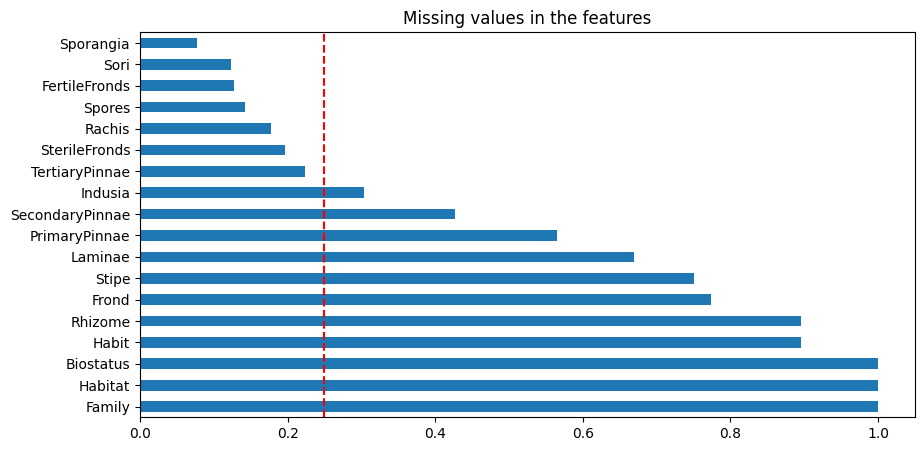

In [331]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
(features.notna().sum()/features.shape[0]).sort_values(ascending=False).plot(kind='barh', figsize=(10, 5), title='Missing values in the features')
ax.axvline(0.25, color='r', linestyle='--')

In [86]:
filt_features = features[features.columns[features.notna().sum()/features.shape[0] > 0.25]]

In [332]:
import numpy as np
import pint
ureg = pint.UnitRegistry()

def range_to_minmax(s):
	if s.lower() in ['', 'nan']:
		return np.array([np.NaN, np.NaN])
	metric = next(re.finditer(unit, s))
	value = s[:metric.start()]
	if '-' in value:
		value = np.array(value.split('-')).astype(float)
	else:
		value = np.array([value, value]).astype(float)
	return ureg.Quantity(value, metric.group()).to('mm').magnitude


s = '115-510mm-long; 40-270mm-wide;...'
s = '115-510mm-long'
def processFeat(s:str, words=('wide', 'long')):
	if s.lower() in ['', 'nan']:
		return pd.Series()
	
	slist = s.split(';')
	m = []
	for w in words:
		firstmeasure = [x.split(f'-{w}')[0].strip() for x in slist if w in x]
		if not firstmeasure:
			# add all the measures with no word found
			firstmeasure = [x.strip() for x in slist if not any([w in x for w in words])]
		firstmeasure = firstmeasure[0] if firstmeasure else ''
		m.append(firstmeasure)

	res = {}
	for x, k in zip(m, words):
		try:
			res |= {f'{k}_{size}': v for size, v in zip(['min', 'max'], range_to_minmax(x))}
		except:
			raise ValueError(x, s, m)
			
	return pd.Series(res)

	
processFeat(s)

wide_min      NaN
wide_max      NaN
long_min    115.0
long_max    510.0
dtype: float64

In [335]:
data = pd.DataFrame()
for c in features.columns.difference(['Family', 'Habitat', 'Habit', 'Biostatus']):
    words = ['wide', 'long']
    if c in ['Frond', 'FertileFrond', 'SterileFrond']:
        words = ['long']

    data = pd.concat([data, 
                      features[c].astype(str).apply(lambda x: processFeat(x, words)).rename(columns={w: f"{c}_{w}" for w in ['wide_min', 'wide_max', 'long_min', 'long_max']})], axis=1)
data = data.join(features[['Family', 'Habitat', 'Biostatus']])


# data = data[data.columns[data.notna().sum()/data.shape[0] > 0.25]]

In [337]:
data.to_csv('processed_features_fern_NUMS.csv')

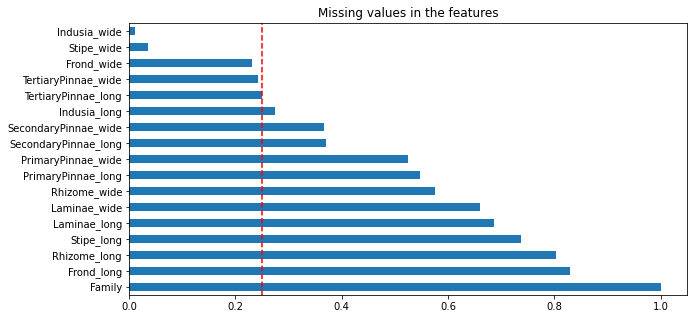

In [84]:
fig, ax = plt.subplots(figsize=(10, 5))
(data.notna().sum()/data.shape[0]).sort_values(ascending=False).plot(kind='barh', figsize=(10, 5), title='Missing values in the features')
ax.axvline(0.25, color='r', linestyle='--')

## Felci Australia

In [3]:
fern_species = pd.read_excel("Australian fern species.xlsx")

In [70]:
from tqdm.auto import tqdm
sp_descriptions = pd.DataFrame()

text = ""
with open(f"Flora of Australia ferns.pdf", "rb") as pdf_file:
    read_pdf = PdfReader(pdf_file)
    for i, page in tqdm(enumerate(read_pdf.pages), total=len(read_pdf.pages)):
        if i < 58:
            continue
        tx = page.extract_text()
        if tx.split("\n")[0].startswith('References'):
            # print(f"Breaking at page {i}")
            break
        text += page.extract_text()
# text = re.sub(r'[^\S\r\n]+', ' ', text)

  0%|          | 0/771 [00:00<?, ?it/s]

In [92]:
def conditional_newline(sp):
    t = '\s*'.join(sp)
    return t.replace('.', '\.').replace('(', '\(').replace(')', '\)').replace('[', '\[').replace(']', '\]')


fern_species['start_pos'] = fern_species.Species.apply(lambda sp: re.search(conditional_newline(sp), text).start())
fern_species = fern_species.sort_values('start_pos')
fern_species['end_pos'] = fern_species.start_pos.shift(-1)
fern_species.loc[fern_species.index[-1], 'end_pos'] = re.search('INCERTAE SEDIS', text).start()
fern_species['end_pos'] = fern_species.end_pos.astype(int)
fern_species['Description'] = fern_species.apply(lambda x: text[x.start_pos:x.end_pos], axis=1)
fern_species.to_excel("fern_species_descriptions_australia.xlsx", index=False)

---

In [ ]:
sp_descriptions = pd.read_excel("fern_species_descriptions_australia.xlsx").set_index('Species')

In [95]:
extra_features_df = pd.read_excel("Australian fern species.xlsx", sheet_name="Traits")
extra_features_df = extra_features_df.drop(columns=[c for c in extra_features_df.columns if 'Unnamed' in c])
extra_features_df = extra_features_df.map(lambda s:s.lower().strip() if type(s) == str else s)

extra_features = extra_features_df.to_dict('list')
extra_features = {k.title().replace(' ', ''): [x for x in v if str(x) != 'nan'] for k, v in extra_features.items()}

In [97]:
unit = '[m|c|d|μ]?m'
number = r"(\d+\.?\d*)"
full_regex = rf"(({number}\s?-\s?)?{number})?({number}\s?-\s?)?{number}\s*{unit}(-wide)?(-long)?"

In [142]:
tmp = []
anomalies = set() # species with anomalies

def extract_features(i, feats:list):
	features = {}
	for feat in feats:
		if len(feat) < 1:
			continue
		feat = feat.replace(',', ' ')
		feat = feat[:-1] if feat[-1] in ['.', ';'] else feat # remove any of .; at the end of the sentence
		candidate_feat = {}
		for key, values in extra_features.items():
			if key in ('Habit', 'Venation', 'Biostatus', 'Habitat'):
				continue
			matched_word = list(re.finditer( r'\b('+ '|'.join([w for w in set(values)]) + r')\b', feat.lower()))
			if any(matched_word):
				candidate_feat[key] = matched_word[0]
		if not any(candidate_feat):
			continue
		key = sorted(candidate_feat, key=lambda x: candidate_feat[x].start())[0]
		matched_word = candidate_feat[key]

		if key == 'Rhizome':
			features['Habit'] = list(set(features.get('Habit', []) + [x for x in extra_features['Habit'] if x in feat.lower()]))
		
		measures = re.finditer(full_regex, feat)
		for measure in measures:
			if key == 'Laminae' and 'primary' in feat.lower() and len(features.get('Laminae', [])) >= 2:
				continue
			if key == 'PrimaryPinnae' and 'secondary' in feat.lower() and len(features.get('PrimaryPinnae', [])) >= 2:
				continue
			
			if key in ['Stipe', 'Laminae', 'Rhizome'] and len(features.get(key, [])) > 1: # TODO: da verificare per caso speciale
				hair_or_scale_position = list(re.finditer(r'(hair|scale)', feat.lower()))
				# C1: Se nella frase dello stipe trovi le keyword "hair", "hairs", "scale", "scales", i valori dopo queste keyword vanno ignorati.
				if any(hair_or_scale_position) and hair_or_scale_position[0].start() < measure.start():
					continue

			features[key] = features.get(key, []) + [measure.group()]
	return pd.Series(features)


In [124]:
def string_preprocessing(s):
	s = s.replace('\xa0', ' ').replace('×', 'x').replace('–', '-').replace('·', '.') # remove non-breaking space and replace multiplication sign with x
	s = re.sub(r'(?<=xcluding)\s+[\w-]+', ' ', s) # remove each word following "excluding" (Mericarps (excluding style) 2.5-3.0 mm should point to "Mericarps")
	s = re.sub(fr'-?\(-?{number}-?\)-?', '', s) # remove all parentesis surrounding a number and the number inside (e.g. (-1.5) --> **)
	s = re.sub(rf'(?<=\d)\s+(?={unit})', '', s) # remove all spaces before measures (mm, cm, dm, m, these strings only if padded by a space)
	s = re.sub('m long;?', 'm-long', s) # remove space between measure and "long" (e.g. 2 mm long --> 2 mm-long)
	s = re.sub('m wide;?', 'm-wide', s) # remove space between measure and "wide" (e.g. 2 mm wide --> 2 mm-wide)
	s = re.sub(r'\s*-\s*', '-', s) # remove spaces around hyphens
	s = re.sub(r'(?<=\d)\s*\.(?=\d)', '.', s) # remove spaces before dot if followed and preceded by a number
	s = re.sub(r'(?<=\s)\.(?=\d)', '0.', s) # add a 0 before a dot if it is preceded by a space and a "not number" and followed by a number (e.g. foo .5 --> foo 0.5)
	# s = re.sub(r'(?<=[\dm])\s*x\s*(?=\d+)', 'x', s) # remove spaces around x in formulas
	s = re.sub(rf'(;\s*)({full_regex})', r' \2', s) # point to any ';' preceding a measure (full_regex) and remove it, without removing the measure
	return s

In [143]:
features = sp_descriptions.Description
# delimiter any of '. ', '.\n' and similar (all the dots not followed by numbers and not preceded by ' c', enforced with a negative lookbehind)
delimiter = r'(?<! c)\.(?!\d)|(; (?=sterile)|(; (?=fertile)))'
delimiter += '|' + '|'.join([f"(; (?={x.lower()}))" for x in extra_features.keys() if x not in ('Habit', 'Venation', 'Biostatus', 'Habitat')])
features = features.apply(string_preprocessing).str.split(delimiter).apply(lambda l: [x.strip() for x in l if x is not None])\
    .reset_index().apply(lambda x: extract_features(x.Species, x.Description), axis=1)

# features = features.map(lambda x: '; '.join(x) if not isinstance(x, float) else x)
# features.index = sp_descriptions.index
# features = features[features.notna().sum(axis=1) > 0].join(sp_descriptions.Family).map(lambda x: x if x != '' else np.nan)

<Axes: title={'center': 'Missing values in the features'}>

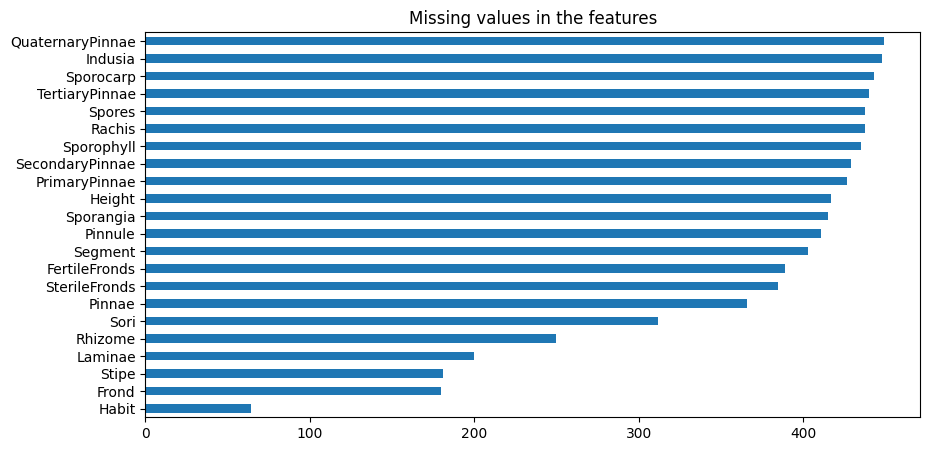

In [147]:
features.isna().sum(axis=0).sort_values().plot(kind='barh', figsize=(10, 5), title='Missing values in the features')

In [ ]:
features.Frond.value_counts()

Habit
[creeping]                            201
[]                                    164
[climbing, creeping]                    7
[aquatic]                               6
[terrestrial, creeping]                 3
[terrestrial]                           2
[climbing]                              2
[climbing, aquatic, creeping]           1
[epiphytic, terrestrial, creeping]      1
[epiphytic]                             1
[epiphytic, creeping]                   1
Name: count, dtype: int64

# S-Analysis

In [35]:
fern_dataset.drop(columns=['Family']).map(lambda x: isinstance(x, str))

,Fertile lamina width min,Fertile lamina width max,Fertile lamina length min,Fertile lamina length max,Ferstipemin,Ferstipemax,Fertile frond min,Fertile frond max,Stipe_long_min,Stipe_long_max,...,Rhizome_wide_max,Rhizome_long_min,Rhizome_long_max,Spore Size min,Spore Size max,Separation,Habitat,Altitudinal Range min,Altitudinal Range max,Hybridisation
Species,,,,,,,,,,,,,,,,,,,,,
Abrodictyum_caudatum,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
Abrodictyum_elongatum,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
Abrodictyum_strictum,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
Adiantum_aethiopicum,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
Adiantum_cunninghamii,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tmesipteris_horomaka,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
Tmesipteris_lanceolata,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
Tmesipteris_sigmatifolia,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


<Axes: >

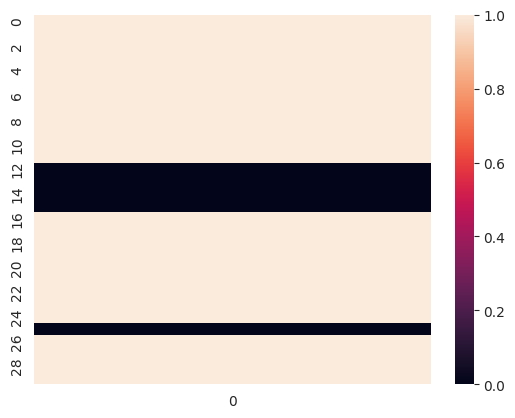

In [7]:
sns.heatmap(np.array(t).reshape(-1, 1))

In [44]:
fern_dataset.select_dtypes(include='bool')

,Separation_yes,Habitat_climbing,Habitat_epiphytic,Habitat_occasionally epiphytic,Habitat_terrestrial
Species,,,,,
Abrodictyum_caudatum,False,False,True,False,False
Abrodictyum_elongatum,False,False,False,False,True
Abrodictyum_strictum,False,False,False,False,True
Adiantum_aethiopicum,False,False,False,False,True
Adiantum_cunninghamii,False,False,False,False,True
...,...,...,...,...,...
Tmesipteris_horomaka,False,False,True,False,False
Tmesipteris_lanceolata,False,False,True,False,False
Tmesipteris_sigmatifolia,False,False,True,False,False


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

fern_dataset = pd.read_excel('Simonny dataset final.xlsx')
fern_dataset.index = fern_dataset.Species.str.replace(' ', '_')
fern_dataset = fern_dataset.drop(columns='Species')

num_cols = fern_dataset.select_dtypes(exclude='object').columns
cat_cols = fern_dataset.select_dtypes(include='object').columns.drop('Family') # Family is the target / it is ignored
fern_dataset = pd.get_dummies(fern_dataset, columns=cat_cols, drop_first=True)


# distance_matrix = pd.read_excel('distance_matrix.xlsx', index_col=0)

# # for all species in fern_dataset which is actually a subspecies (Species_name_subs._subname), replace the corresponding row and column in the distance matrix (which only have the main species)
# # with as many row/columns as the number of subspecies

# subspecies = [x for x in fern_dataset.index if 'subsp.' in x]
# for sub in subspecies:
#     main_species = sub.split('_subsp.')[0]
#     distance_matrix.loc[main_species] = distance_matrix.loc[main_species]
#     distance_matrix[main_species] = distance_matrix[main_species]

# # all subspecies have distance 0 from each other, then remove the rows and columns of the main species
# for ms in set([x.split('_subsp.')[0] for x in subspecies]):
#     distance_matrix = distance_matrix.drop(ms, axis=0).drop(ms, axis=1)
#     distance_matrix.loc[[i for i in distance_matrix.index if i.startswith(ms)], [i for i in distance_matrix.columns if i.startswith(ms)]] = 0

# available_species = fern_dataset.index.intersection(distance_matrix.index)
# # fern_dataset = fern_dataset.loc[available_species]
# distance_matrix = distance_matrix.loc[available_species, available_species]

# g = sns.heatmap(distance_matrix)

In [30]:
num_cols = fern_dataset.select_dtypes(exclude='object').columns
fern_dataset[fern_dataset.columns.difference(num_cols)]

,Family,Habitat
Species,,
Abrodictyum_caudatum,Hymenophyllaceae,epiphytic
Abrodictyum_elongatum,Hymenophyllaceae,terrestrial
Abrodictyum_strictum,Hymenophyllaceae,terrestrial
Adiantum_aethiopicum,Pteridaceae,terrestrial
Adiantum_cunninghamii,Pteridaceae,terrestrial
...,...,...
Tmesipteris_horomaka,Psilotaceae,epiphytic
Tmesipteris_lanceolata,Psilotaceae,epiphytic
Tmesipteris_sigmatifolia,Psilotaceae,epiphytic


In [31]:
fern_dataset.select_dtypes(include='object').columns.difference(['Species', 'Family'])

Index(['Habitat'], dtype='object')

In [28]:
pd.get_dummies(fern_dataset, columns=fern_dataset.select_dtypes(include='object').columns.difference(['Species', 'Family']))

,Species,Family,Fertile lamina width min,Fertile lamina width max,Fertile lamina length min,Fertile lamina length max,Ferstipemin,Ferstipemax,Fertile frond min,Fertile frond max,...,Altitudinal Range min,Altitudinal Range max,Hybridisation,Habitat_acquatic,Habitat_climbing,Habitat_epiphytic,Habitat_occasionally epiphytic,Habitat_terrestrial,Separation_no,Separation_yes
0,Abrodictyum caudatum,Hymenophyllaceae,8.0,16.0,12.0,50.0,2.0,20.0,18.0,65.0,...,10.0,20.0,0,False,False,True,False,False,True,False
1,Abrodictyum elongatum,Hymenophyllaceae,26.0,100.0,48.0,140.0,30.0,250.0,95.0,360.0,...,10.0,700.0,0,False,False,False,False,True,True,False
2,Abrodictyum strictum,Hymenophyllaceae,15.0,80.0,40.0,260.0,20.0,160.0,65.0,350.0,...,10.0,900.0,0,False,False,False,False,True,True,False
3,Adiantum aethiopicum,Pteridaceae,25.0,170.0,80.0,400.0,35.0,330.0,125.0,500.0,...,0.0,240.0,0,False,False,False,False,True,True,False
4,Adiantum cunninghamii,Pteridaceae,25.0,260.0,40.0,370.0,20.0,530.0,60.0,900.0,...,0.0,1100.0,0,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,Tmesipteris horomaka,Psilotaceae,2.5,7.0,10.0,25.0,0.0,0.0,10.0,25.0,...,120.0,610.0,0,False,False,True,False,False,True,False
203,Tmesipteris lanceolata,Psilotaceae,2.0,8.5,7.0,23.0,0.0,0.0,7.0,23.0,...,0.0,500.0,0,False,False,True,False,False,True,False
204,Tmesipteris sigmatifolia,Psilotaceae,2.0,4.0,8.0,20.0,0.0,0.0,8.0,20.0,...,0.0,400.0,0,False,False,True,False,False,True,False
205,Tmesipteris tannensis,Psilotaceae,2.0,8.0,7.0,28.0,0.0,0.0,7.0,28.0,...,0.0,1075.0,0,False,False,False,True,False,True,False


In [2]:
from sklearn.impute import KNNImputer as _KNNImputer
from sklearn.impute import SimpleImputer as _SimpleImputer

# knn imputer which takes both num and cat values but ignores the categorical ones
class KNNImputer(_KNNImputer):
    def fit(self, X, y=None):
        self.num_features = X.select_dtypes(include=[np.number]).columns
        self.cat_features = X.select_dtypes(exclude=[np.number]).columns
        self.num_imputer = _KNNImputer(n_neighbors=self.n_neighbors).fit(X[self.num_features])
        return self
    
    def transform(self, X):
        X_ = X.copy()
        X_[self.num_features] = self.num_imputer.transform(X_[self.num_features])
        return X_

# simple imputer which takes both num and cat values but ignores the categorical ones
class SimpleImputer(_SimpleImputer):
    def fit(self, X, y=None):
        self.num_features = X.select_dtypes(include=[np.number]).columns
        self.cat_features = X.select_dtypes(exclude=[np.number]).columns
        self.num_imputer = _SimpleImputer(strategy=self.strategy).fit(X[self.num_features])
        return self
    
    def transform(self, X):
        X_ = X.copy()
        X_[self.num_features] = self.num_imputer.transform(X_[self.num_features])
        return X_

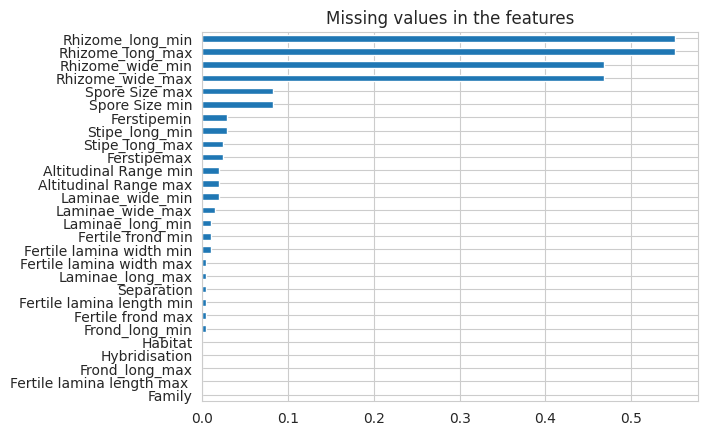

In [3]:
g = fern_dataset.isna().mean().sort_values().plot(kind='barh', title='Missing values in the features')

In [4]:
# instead:
from argparse import Namespace
args = Namespace(train_edge=0.7, split_sample=0., split_by='y', 
                 train_y=0.7, node_mode=0, model_types='EGSAGE_EGSAGE_EGSAGE', post_hiddens=None, 
                 norm_embs=None, aggr='mean', node_dim=64, edge_dim=64, concat_states=False,
                 edge_mode=1, gnn_activation='relu', impute_hiddens='64', impute_activation='relu', 
                 epochs=2000, opt='adam', opt_scheduler='none', opt_restart=0, opt_decay_step=100, 
                 opt_decay_rate=0.9, dropout=0., weight_decay=0., lr=0.001, known=0.7, auto_known=False,
                 loss_mode=0, valid=0., seed=42, mode='train')

In [25]:
from sys import path
import torch
import torch.nn.functional as F

path.append('../GRAPE')
from models.gnn_model import get_gnn
from models.prediction_model import MLPNet
from utils.utils import build_optimizer, get_known_mask, mask_edge
from uci.uci_data import get_data


class GRAPEImputer:
    def __init__(self, args, device='cuda'):
        self.model = None
        self.args = args
        self.device = device
        impute_hiddens = list(map(int,args.impute_hiddens.split('_')))
        input_dim = args.node_dim * 2
        output_dim = 1

        self.impute_model = MLPNet(input_dim, output_dim,
                                hidden_layer_sizes=impute_hiddens,
                                hidden_activation=args.impute_activation,
                                dropout=args.dropout).to(device)

    def load_data(self, Xy):
        df_X = Xy.drop(columns='Family')
        df_y = Xy.Family
        df_y = pd.Series(pd.Categorical(df_y).codes)
        data = get_data(df_X, df_y, self.args.node_mode, self.args.train_edge, 
                        self.args.split_sample, self.args.split_by, self.args.train_y, self.args.seed)
        return data

    def fit(self, Xy):
        # build data on top of X
        data = self.load_data(Xy)
        self.model = get_gnn(data, self.args)
        trainable_parameters = list(self.model.parameters()) \
                            + list(self.impute_model.parameters())
        print("total trainable_parameters: ",len(trainable_parameters))
        # build optimizer
        scheduler, opt = build_optimizer(self.args, trainable_parameters)

        # train
        self.Train_loss = []
        self.Test_rmse = []
        self.Test_l1 = []
        self.Lr = []

        x = data.x.clone().detach().to(self.device)
        
        all_train_edge_index = data.train_edge_index.clone().detach().to(self.device)
        all_train_edge_attr = data.train_edge_attr.clone().detach().to(self.device)
        all_train_labels = data.train_labels.clone().detach().to(self.device)
        test_input_edge_index = all_train_edge_index
        test_input_edge_attr = all_train_edge_attr
        test_edge_index = data.test_edge_index.clone().detach().to(self.device)
        test_edge_attr = data.test_edge_attr.clone().detach().to(self.device)
        test_labels = data.test_labels.clone().detach().to(self.device)
        
        
        train_edge_index, train_edge_attr, train_labels =\
            all_train_edge_index, all_train_edge_attr, all_train_labels
        print("train edge num is {}, test edge num is input {}, output {}"\
                .format(
                train_edge_attr.shape[0],
                test_input_edge_attr.shape[0], test_edge_attr.shape[0]))
        
        for epoch in range(self.args.epochs):
            self.model.train()
            self.impute_model.train()
            known_mask = get_known_mask(self.args.known, int(train_edge_attr.shape[0] / 2)).to(self.device)
            double_known_mask = torch.cat((known_mask, known_mask), dim=0)
            known_edge_index, known_edge_attr = mask_edge(train_edge_index, train_edge_attr, double_known_mask, True)

            opt.zero_grad()
            x_embd = self.model(x, known_edge_attr, known_edge_index)
            pred = self.impute_model([x_embd[train_edge_index[0]], x_embd[train_edge_index[1]]])
            pred_train = pred[:int(train_edge_attr.shape[0] / 2),0]
            label_train = train_labels

            loss = F.mse_loss(pred_train, label_train)
            loss.backward()
            opt.step()
            train_loss = loss.item()
            if scheduler is not None:
                scheduler.step(epoch)
            for param_group in opt.param_groups:
                self.Lr.append(param_group['lr'])

            self.model.eval()
            self.impute_model.eval()
            with torch.no_grad():
                x_embd = self.model(x, test_input_edge_attr, test_input_edge_index)
                pred = self.impute_model([x_embd[test_edge_index[0], :], x_embd[test_edge_index[1], :]])
                
                pred_test = pred[:int(test_edge_attr.shape[0] / 2),0]
                label_test = test_labels
                mse = F.mse_loss(pred_test, label_test)
                test_rmse = np.sqrt(mse.item())
                l1 = F.l1_loss(pred_test, label_test)
                test_l1 = l1.item()
                
                self.Train_loss.append(train_loss)
                self.Test_rmse.append(test_rmse)
                self.Test_l1.append(test_l1)
                print('epoch: ', epoch)
                print('loss: ', train_loss)
                print('test rmse: ', test_rmse)
                print('test l1: ', test_l1)

        self.pred_train = pred_train.detach().cpu().numpy()
        self.label_train = label_train.detach().cpu().numpy()
        self.pred_test = pred_test.detach().cpu().numpy()
        self.label_test = label_test.detach().cpu().numpy()
        return self

    def fit_transform(self, X):
        self.fit(X)
        return self.pred_test

    def transform(self, X):
        # TODO: fare meglio, ora ignora X e usa il test set
        return self.pred_test

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split


# TODO: al momento GRAPE vuole anche la famiglia, gli altri no!
train, test = train_test_split(fern_dataset, test_size=.3, shuffle=True, random_state=42)

# default estimators are lgbm classifier and regressor
grape = GRAPEImputer(args)
# TODO: managing cat features inside
grape.fit(fern_dataset.drop(columns=['Separation', 'Habitat']))
test_imputed = grape.transform(test)

['EGSAGE', 'EGSAGE', 'EGSAGE'] [True, True, True] [64]
total trainable_parameters:  26
train edge num is 7318, test edge num is input 7318, output 3032


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [77]:
# alternatives (old): https://github.com/iskandr/fancyimpute

from sklearn.model_selection import GroupKFold
from missforest.missforest import MissForest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from tqdm.auto import tqdm

float_cols = fern_dataset.columns[fern_dataset.dtypes == 'float']
def mape_with_mask(y_true, y_pred, mask):
    assert y_true.shape == y_pred.shape and y_true.shape == mask.shape, f"{y_true.shape}, {y_pred.shape}, {mask.shape}"
    results = {c: ((y_true[c][mask[c]] - y_pred[c][mask[c]]).abs() / y_true[c][mask[c]]).mean() for c in mask.columns}
    return pd.Series(results)

kf = GroupKFold(n_splits=5)

# models = [MissForest(), SimpleImputer(strategy='mean'), KNNImputer()]
models = [SimpleImputer(strategy='mean'), KNNImputer()]
results = pd.DataFrame(np.hstack([
    fern_dataset[float_cols].isna().mean().values.reshape(-1, 1), np.zeros([len(float_cols), len(models)])
    ]), columns=['Missing ratio'] + [m.__class__.__name__ for m in models], index=float_cols).sort_values('Missing ratio')

for i, (train_index, test_index) in tqdm(enumerate(kf.split(fern_dataset, groups=fern_dataset.Family)), total=kf.get_n_splits()):
    filt_ds = fern_dataset.drop(columns=['Family']).copy()
    # for each column with numerical values, add an extra 15% of missing values

    for col in float_cols:
        filt_ds.loc[filt_ds[filt_ds[col].notna()].sample(n=len(filt_ds)//100*15).index, col] = np.nan

    train, test = filt_ds.iloc[train_index].copy(), filt_ds.iloc[test_index].copy()
    hiddenvals_mask = (filt_ds[float_cols].isna() & fern_dataset[float_cols].notna()).fillna(False).iloc[test_index]
    for model in models:
        if model.__class__.__name__ == 'MissForest':
            model.fit(train.copy(), categorical=filt_ds.columns[filt_ds.dtypes == 'object'])
        else:
            model.fit(train)
        try:
            imputed = model.transform(test.copy())
        except:
            print(model.__class__.__name__, i)
            imputed = test.copy()
        results.loc[:, model.__class__.__name__] += mape_with_mask(fern_dataset[float_cols].iloc[test_index], imputed[float_cols], hiddenvals_mask)

results = results.div(kf.get_n_splits())
results.loc[float_cols].sort_values('Missing ratio')





  0%|          | 0/5 [00:00<?, ?it/s]

/home/smonaco/miniconda3/lib/python3.10/site-packages/missforest/missforest.py:227: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x[c].fillna(initial_imputations[c], inplace=True)
/home/smonaco/miniconda3/lib/python3.10/site-packages/missforest/missforest.py:227: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values

MissForest 0
MissForest 1
MissForest 2
MissForest 3
MissForest 4


/home/smonaco/miniconda3/lib/python3.10/site-packages/missforest/missforest.py:227: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x[c].fillna(initial_imputations[c], inplace=True)
/home/smonaco/miniconda3/lib/python3.10/site-packages/missforest/missforest.py:227: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values

,Missing ratio,MissForest,SimpleImputer,KNNImputer
Fertile lamina length max,0.000000,NaN,7.222594,2.864200
Frond_long_max,0.000000,NaN,10.266816,0.743869
Fertile lamina length min,0.000966,NaN,15.339002,1.710482
Fertile lamina width max,0.000966,NaN,16.434671,1.399854
Frond_long_min,0.000966,NaN,7.201169,1.446602
Laminae_long_max,0.000966,NaN,5.083710,0.592709
Fertile frond max,0.000966,NaN,4.588332,0.654660
Fertile lamina width min,0.001932,NaN,8.846803,1.973097
Fertile frond min,0.001932,NaN,17.490575,3.012099
Laminae_long_min,0.001932,NaN,9.108274,2.175701


In [119]:
float_cols = fern_dataset.columns[fern_dataset.dtypes == 'float']
known_values_idx = np.arange(fern_dataset[float_cols].notna().values.sum())
from sklearn.model_selection import train_test_split
train, test = train_test_split(known_values_idx, test_size=.25, shuffle=True, random_state=42)

filt_ds = fern_dataset.drop(columns=['Family']).copy()
values = fern_dataset[float_cols].values.flatten()
values[test] = np.nan

filt_ds.loc[:, float_cols] = values.reshape(-1, len(float_cols))

In [118]:
len(test) + len(train) + np.isnan(fern_dataset[float_cols].values.flatten()).sum() == fern_dataset.shape[0] * fern_dataset[float_cols].shape[1]

True

In [114]:
np.isnan(fern_dataset[float_cols].values.flatten()).sum()

504